# Forecasting beer sales 

github: https://github.com/kohlicekjan/forecasting-beer-sales-ml

### Source
- https://scikit-learn.org/stable/index.html
- https://www.mariofilho.com/how-to-predict-multiple-time-series-with-scikit-learn-with-sales-forecasting-example/
- https://alkaline-ml.com/pmdarima/quickstart.html
- https://facebook.github.io/prophet/

In [1239]:
import pandas as pd
import numpy as np
import os
import datetime

from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [1241]:
DATASET_NAME = 'off-trade'

DATA_PATH = f'./data/{DATASET_NAME}_data.csv'

MODEL_PATH = f'./models/{DATASET_NAME}_model.joblib'

RESULT_CSV_PATH = f'./results/{DATASET_NAME}_result.csv'
RESULT_EXCEL_PATH = f'./results/{DATASET_NAME}_result.xlsx'

In [1243]:
data = pd.read_csv(DATA_PATH, header=0, decimal=",")

data = data.fillna(-1)

#data['Date'] = data[['Year','Week']].apply(lambda x : datetime.datetime.strptime(f'{x[0]}-W{x[1]}-1', "%Y-W%W-%w"), axis=1)
#data.Date = data.Date.map(datetime.datetime.toordinal)

data.IsLockdown = data.IsLockdown.astype('bool')
data.SkuShort = data.SkuShort.astype('category')
data.ProductGroup = data.SkuShort.astype('category')
data.PrimaryPack = data.SkuShort.astype('category')
data.Country = data.Country.astype('category').cat.codes

#data['PrevWeekSalesDiff'] = data.PrevWeekSalesHl1-data.PrevWeekSalesHl2

#data = data.drop(['PrevWeekSalesHl1', 'PrevWeekSalesHl2'], axis=1)

# data.at[((data.Year == 2020) & (data.Week == 50)), 'IsLockdown'] = False
# data.at[((data.Year == 2020) & (data.Week == 51)), 'IsLockdown'] = False

data.head()

,SkuShort,ProductGroup,PrimaryPack,Country,Year,Week,NumberWorkdays,AvgTemp,AvgRain,AvgSun,IsLockdown,PdtHl,PrevWeekPdtHl1,BgtHl,PrevWeekBgtHl1,SalesHl,PrevWeekSalesHl1,PrevWeekSalesHl2,OldPredSalesHl
0,1015,1015,1015,0,2016,1,5,-1.164286,0.935714,1.014286,False,-1.0,-1.0,1637.344974,-1.0,1805.0000,-1.0,-1.0,705.4995
1,1016,1016,1016,0,2016,1,5,-1.164286,0.935714,1.014286,False,-1.0,-1.0,293.344724,-1.0,159.1128,-1.0,-1.0,160.0957
2,1022,1022,1022,0,2016,1,5,-1.164286,0.935714,1.014286,False,-1.0,-1.0,59.144115,-1.0,72.4900,-1.0,-1.0,74.4420
3,1026,1026,1026,0,2016,1,5,-1.164286,0.935714,1.014286,False,-1.0,-1.0,10.669629,-1.0,23.8392,-1.0,-1.0,8.8567
4,1027,1027,1027,0,2016,1,5,-1.164286,0.935714,1.014286,False,-1.0,-1.0,2.109411,-1.0,3.9600,-1.0,-1.0,4.9003


In [1245]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47370 entries, 0 to 47369
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   SkuShort          47370 non-null  category
 1   ProductGroup      47370 non-null  category
 2   PrimaryPack       47370 non-null  category
 3   Country           47370 non-null  int8    
 4   Year              47370 non-null  int64   
 5   Week              47370 non-null  int64   
 6   NumberWorkdays    47370 non-null  int64   
 7   AvgTemp           47370 non-null  float64 
 8   AvgRain           47370 non-null  float64 
 9   AvgSun            47370 non-null  float64 
 10  IsLockdown        47370 non-null  bool    
 11  PdtHl             47370 non-null  float64 
 12  PrevWeekPdtHl1    47370 non-null  float64 
 13  BgtHl             47370 non-null  float64 
 14  PrevWeekBgtHl1    47370 non-null  float64 
 15  SalesHl           47370 non-null  float64 
 16  PrevWeekSalesHl1  4737

In [1247]:
# train = data[(data.Year <= 2019) | (data.Year == 2021) | ((data.Year == 2020) & (data.Week < 45))]
# test = data[(data.Year == 2020) & (data.Week >= 45)]

train = data[(data.Year <= 2020) | ((data.Year == 2021) & (data.Week < 10))]
test = data[(data.Year == 2021) & (data.Week >= 10)]

# #train = train.append([train[train.IsLockdown == 1]]*2, ignore_index=True)


# if (DATASET_NAME == 'off-trade'):
#     cols_drop = ['SalesHl', 'OldPredSalesHl', 'SkuShort', 'ProductGroup', 'Country']
# else:
#     cols_drop = ['SalesHl', 'OldPredSalesHl', 'SkuShort', 'ProductGroup']

cols_drop = ['SalesHl', 'OldPredSalesHl']


#'SkuShort', 'ProductGroup', 'PrimaryPack', 'Country', 'Year'

y_train = pd.DataFrame(train.SalesHl).round(0).astype(int)
X_train = train.drop(cols_drop, axis=1)

y_test = pd.DataFrame(test.SalesHl).round(0).astype(int)
X_test = test.drop(cols_drop, axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train.head()


y_oldPred = pd.DataFrame(test.OldPredSalesHl).fillna(0).round(0).astype(int)

In [1249]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, max_error, mean_absolute_percentage_error

from sklearn import ensemble, gaussian_process, isotonic, kernel_ridge, linear_model, neighbors, neural_network, svm, tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.experimental import enable_hist_gradient_boosting

# Create linear regression object

#NOT model = ensemble.AdaBoostRegressor()
#model = ensemble.BaggingRegressor() # ON-TRADE: ,OFF-TRADE: 0.79 {'base_estimator': DecisionTreeRegressor(random_state=0), 'bootstrap': True, 'bootstrap_features': False, 'n_estimators': 200, 'oob_score': False, 'verbose': 1, 'warm_start': True}
#model = ensemble.ExtraTreesRegressor(n_jobs=3) # ON-TRADE: ,OFF-TRADE: 0.7962
#model = ensemble.GradientBoostingRegressor()
#model = ensemble.RandomForestRegressor(n_estimators=1000, n_jobs=6) # ON-TRADE: ,OFF-TRADE: 0.7933 {'bootstrap': True, 'criterion': 'mae', 'oob_score': True, 'warm_start': False}
#NOT model = ensemble.StackingRegressor(estimators=[('lgbm', lgb.LGBMRegressor()),('hgb', ensemble.HistGradientBoostingRegressor())],final_estimator=ensemble.BaggingRegressor(), n_jobs=4, passthrough=False) 
#model = ensemble.VotingRegressor([('lgbm', lgb.LGBMRegressor(n_estimators=5000, learning_rate=0.005)), ('rf', ensemble.RandomForestRegressor(n_estimators=1000))]) # ON-TRADE: ,OFF-TRADE: 0.8143
#model = ensemble.HistGradientBoostingRegressor(early_stopping=False) # ON-TRADE: ,OFF-TRADE: 0.7937 {'learning_rate': 0.01, 'loss': 'least_squares', 'max_iter': 1000, 'max_leaf_nodes': 70}

#NOT model = gaussian_process.GaussianProcessRegressor()
#NOT model = isotonic.IsotonicRegression()

#NOT model = kernel_ridge.KernelRidge(alpha=1.0)# ON-TRADE: ,OFF-TRADE: 0.7827

# #option CV
#SLOW model = linear_model.LogisticRegression(max_iter=100)
#model = linear_model.LinearRegression()# ON-TRADE: ,OFF-TRADE: 0.7875 {'copy_X': False, 'fit_intercept': True, 'normalize': False, 'positive': False}
#model = linear_model.Ridge(max_iter=1000)# ON-TRADE: ,OFF-TRADE: 0.7876 {'alpha': 0.005, 'copy_X': False, 'fit_intercept': True, 'normalize': True, 'solver': 'sparse_cg'}
#model = linear_model.SGDRegressor(max_iter=1500, early_stopping=False) # ON-TRADE: ,OFF-TRADE:  0.7819 {'alpha': 0.0001, 'average': True, 'epsilon': 0.1, 'eta0': 0.01, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'invscaling', 'loss': 'huber', 'penalty': 'l2', 'power_t': 0.1, 'shuffle': True, 'verbose': False, 'warm_start': True}

#model = linear_model.ElasticNet(max_iter=2000)# ON-TRADE: ,OFF-TRADE: 0.7875 {'alpha': 0.001, 'copy_X': False, 'fit_intercept': True, 'l1_ratio': 1, 'normalize': True, 'positive': False, 'precompute': False, 'selection': 'random', 'warm_start': True}
#model = linear_model.Lars(n_nonzero_coefs=1000) # ON-TRADE: , OFF-TRADE: 0.7875 {'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': False, 'precompute': False, 'verbose': True}
#model = linear_model.LassoLars(max_iter=500) # ON-TRADE: , OFF-TRADE: 0.7875 {'alpha': 0.001, 'copy_X': True, 'fit_intercept': True, 'fit_path': True, 'jitter': False, 'normalize': True, 'positive': False, 'precompute': True, 'verbose': True}
#model = linear_model.OrthogonalMatchingPursuit() # ON-TRADE: , OFF-TRADE: 0.7035 {'fit_intercept': True, 'normalize': True}
#model = linear_model.ARDRegression(n_iter=500) # ON-TRADE: , OFF-TRADE: 0.7875 {'compute_score': True, 'copy_X': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}
#model = linear_model.BayesianRidge(n_iter=500) # ON-TRADE: , OFF-TRADE: 0.7875 {'compute_score': True, 'copy_X': True, 'fit_intercept': True, 'normalize': True, 'verbose': True}

#model = linear_model.HuberRegressor(max_iter=500) # ON-TRADE: , OFF-TRADE: 0.7805 {'epsilon': 1.6, 'fit_intercept': True, 'warm_start': True}
#model = linear_model.RANSACRegressor(max_trials=500) #O N-TRADE: , OFF-TRADE: 0.7225
#model = linear_model.TheilSenRegressor(max_iter=500, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7582 {'copy_X': False, 'fit_intercept': True, 'verbose': True}

#NOT model = linear_model.PoissonRegressor(max_iter=500)
# model = linear_model.TweedieRegressor(max_iter=500) # ON-TRADE: , OFF-TRADE: 0.7871 {'alpha': 0.05, 'fit_intercept': False, 'link': 'auto', 'power': 0, 'warm_start': True}
#NOT model = linear_model.GammaRegressor(max_iter=500) # ON-TRADE: ,OFF-TRADE:
#NOT model = linear_model.PassiveAggressiveRegressor(random_state=0, fit_intercept=True) # ON-TRADE: , OFF-TRADE: 0.6938

#model = neighbors.KNeighborsRegressor(n_neighbors=7, weights='uniform', leaf_size=30, n_jobs=-1) # ON-TRADE: , OFF-TRADE: 0.7941
#NOT model = neighbors.RadiusNeighborsRegressor(radius=5.0, weights='distance')

#NOT model = svm.LinearSVR() # ON-TRADE: , OFF-TRADE: 0.7049
#model = ensemble.HistGradientBoostingRegressor(random_state=1, loss='least_squares', learning_rate=0.05, max_iter=350, max_leaf_nodes=70, early_stopping=False)

#param_grid = dict(criterion=['mse','mae'])
# #alpha=[1, 0.5, 0.1, 0.05, 0.001, 0.0005, 0.0001],fit_intercept=[True, False], verbose=[True, False], normalize=[True, False], precompute=[True, False], copy_X=[True, False], fit_path=[True, False], positive=[True, False], jitter=[True, False]
# clf = GridSearchCV(model, param_grid, n_jobs=2) #, random_state=0
# search = clf.fit(X_train, y_train.values.ravel())
# #print(search.cv_results_)
# print(search.best_score_)
# print(search.best_params_)


mlpModel = neural_network.MLPRegressor(activation='relu', solver='adam', learning_rate='constant', nesterovs_momentum=True, shuffle=False, verbose=False, warm_start=True, random_state=1, hidden_layer_sizes=60, max_iter=1000, early_stopping=False)
lgbmModel = lgb.LGBMRegressor(n_estimators=10000, learning_rate=0.001, num_leaves=300, n_jobs=6)

model = ensemble.VotingRegressor([('lgbm', lgbmModel), ('mlp', mlpModel)])


# Train the model using the training sets
model.fit(X_train, y_train.values.ravel())

# Make predictions using the testing set
y_pred = model.predict(X_test)
y_pred[y_pred < 0] = 0

# # The mean squared error
# print('Mean squared error: %.4f'% mean_squared_error(y_test, y_pred))

print(DATASET_NAME)
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.4f'% r2_score(y_test, y_pred))

# #Best possible score is 1.0, lower values are worse.
# print('Explained variance regression: %.4f'% explained_variance_score(y_test, y_pred))

#max_error metric calculates the maximum residual error.
print('Maximum residual error: %.4f'% max_error(y_test, y_pred))

# #Mean absolute percentage error regression loss.
# print('Mean absolute percentage error regression loss: %.4f'% mean_absolute_percentage_error(y_test, y_pred))

print('Old Coefficient of determination: %.4f'% r2_score(y_test, y_oldPred))
print('Old Maximum residual error: %.4f'% max_error(y_test, y_oldPred))

# print(f'The number of iterations as selected by early stopping: {model.n_iter_}')
# print(f'The scores at each iteration on the training data: {model.train_score_}')
# print(f'The scores at each iteration on the held-out validation data: {model.validation_score_}')
# print(f'Boolean mask for the categorical features: {model.is_categorical_}')

#on-trade
#0.8547 ['SalesHl', 'OldPredSalesHl']
#0.8547 ['SalesHl', 'OldPredSalesHl', 'SkuShort']
#0.8547 ['SalesHl', 'OldPredSalesHl', 'SkuShort', 'ProductGroup']

#off-trade
#0.8432 ['SalesHl', 'OldPredSalesHl']
#0.8432 ['SalesHl', 'OldPredSalesHl', 'SkuShort']
#0.8495 ['SalesHl', 'OldPredSalesHl', 'SkuShort', 'ProductGroup', 'Country']



#on-trade
#0.8117

off-trade
Coefficient of determination: 0.8687
Maximum residual error: 5899.1181
Old Coefficient of determination: 0.9544
Old Maximum residual error: 4029.0000
C:\Users\K\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


In [1251]:
def get_percentage_diff(previous, current):
    return 1 - (abs(previous - current)/max(previous, current))

result = test.copy(deep=False)
result["PredictSalesHl"] = y_pred

resultWeek = result.groupby(['Year','Week']).sum()
resultWeek = resultWeek[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultWeek['NewPredSalesHlDiff'] = resultWeek.NewPredSalesHl-resultWeek.OldPredSalesHl
resultWeek = (100. * resultWeek).round(1).astype(str) + '%'
print(resultWeek)

resultYear = result.groupby(['Year']).sum()
resultYear= resultYear[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
resultYear['NewPredSalesHlDiff'] = resultYear.NewPredSalesHl-resultYear.OldPredSalesHl
resultYear = (100. * resultYear).round(1).astype(str) + '%'
print(resultYear)

# resultSkuShort = result.groupby(['SkuShort']).sum()
# resultSkuShort = resultSkuShort[['SalesHl', 'OldPredSalesHl', 'PredictSalesHl']].apply(lambda x : pd.Series({'OldPredSalesHl': get_percentage_diff(x[0], x[1]), 'NewPredSalesHl': get_percentage_diff(x[0], x[2])}) , axis=1)
# resultSkuShort['NewPredSalesHlDiff'] = resultSkuShort.NewPredSalesHl-resultSkuShort.OldPredSalesHl
# resultSkuShort = (100. * resultSkuShort).round(1).astype(str) + '%'

# print(resultSkuShort)

          OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year Week                                                 
2021 10            97.8%          99.1%               1.3%
     11            93.7%          91.3%              -2.5%
     12            95.4%          81.3%             -14.1%
     13            91.6%          87.3%              -4.3%
     14            90.5%          95.8%               5.3%
     15            98.1%          91.2%              -6.9%
     16            92.6%          92.0%              -0.6%
     17            98.9%          80.0%             -18.8%
     18            91.4%          96.3%               4.9%
     19            92.9%          98.4%               5.5%
     OldPredSalesHl NewPredSalesHl NewPredSalesHlDiff
Year                                                 
2021          94.6%          92.7%              -1.9%


## Model analysis

In [1253]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

feature_names = X_train.columns.tolist()
examples_numpy = pd.concat([X_train.sample(n=200), X_test.sample(n=200)]).to_numpy()

# wrap our base model with InMemoryModel instance
annotated_model = InMemoryModel(
    model.predict, 
    examples = examples_numpy, 
    model_type = 'regressor'
)

interpreter = Interpretation(examples_numpy, feature_names=feature_names)


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

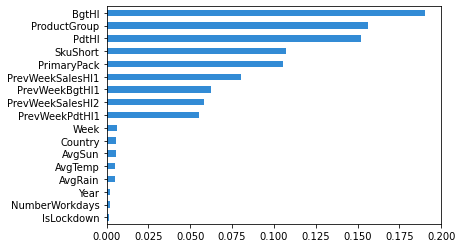

In [1255]:
interpreter.feature_importance.plot_feature_importance(annotated_model, progressbar=False)

In [1257]:
# interpreter.partial_dependence.plot_partial_dependence(
#     feature_names, annotated_model, grid_resolution=20, progressbar=False
# )

In [1259]:
# from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

# # create an explainer
# explainer = LimeTabularExplainer(examples_numpy, feature_names=feature_names, mode="regression")

# # explain something
# explanation = explainer.explain_instance(examples_numpy[5], annotated_model)

# # show the explanation
# explanation.show_in_notebook()

In [1261]:
# import shap
# #shap.initjs()

# X100 = shap.utils.sample(train, 100)

# explainer = shap.Explainer(model)
# shap_values = explainer(X100)

# shap.plots.waterfall(shap_values[0])

In [1262]:
# shap.plots.force(shap_values[0])

In [1263]:
# shap.plots.force(shap_values)

In [1264]:
# shap.plots.scatter(shap_values, color=shap_values)

In [1265]:
# shap.plots.bar(shap_values)

In [1266]:
# shap.plots.beeswarm(shap_values)

## Save Result

In [1267]:
result = test.copy(deep=False)
result["PredictSalesHl"] = y_pred

dir_path = os.path.dirname(RESULT_CSV_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)
 
result.to_csv(RESULT_CSV_PATH, index=False)
result.to_excel(RESULT_EXCEL_PATH, index=False)

## Save model

In [1268]:
import joblib

dir_path = os.path.dirname(MODEL_PATH)
if (not os.path.isdir(dir_path)):
    os.mkdir(dir_path)

joblib.dump(model, MODEL_PATH, compress=True)

['./models/off-trade_model.joblib']

## Use model

In [1269]:
# import joblib
# import os
# import numpy as np

# file = open(MODEL_PATH, 'rb')

# model = joblib.load(file)

# SkuShort = 2605
# Week = 23
# NumberWorkdays = 5
# AvgTemp = 15.892857142857142
# AvgRain = 3.5000000000000004
# AvgSun = 6.735714285714286
# IsLockdown = 0
# PdtHl = -1.0
# PrevWeekPdtHl1 = -1.0
# BgtHl = 6665
# PrevWeekBgtHl1 = 6665.949490847161
# PrevWeekSalesHl1 = 5020
# PrevWeekSalesHl2 = 5038
# SalesHl = 5386.5

# x = np.array([[SkuShort, Week,NumberWorkdays, AvgTemp, AvgRain, AvgSun, IsLockdown, PdtHl, PrevWeekPdtHl1, BgtHl, PrevWeekBgtHl1, PrevWeekSalesHl1, PrevWeekSalesHl2]])

# y_pred = model.predict(x)
# result = y_pred[0]

# def get_percentage_diff(previous, current):
#     return 1 - (abs(previous - current)/max(previous, current))

# print('Forecast sales: %.4f hl'% result)
# print('Coefficient of determination: %.4f'% get_percentage_diff(SalesHl, result))

#full with sku = 0.7678
#full = 0.7363